# Example: Blowfly Model
Likelihood-free inference for the blow-fly model was introduced by [Simon N.
Wood](http://dx.doi.org/10.1038/nature09319). We model here the discrete time
stochastic dynamics of the size ``N`` of an adult blowfly population as given in [section 1.2.3 of the supplementary
information](https://static-content.springer.com/esm/art%3A10.1038%2Fnature09319/MediaObjects/41586_2010_BFnature09319_MOESM302_ESM.pdf).
$$
N_{t+1} = P N_{t-\tau}\exp(-N_{t-\tau}/N_0)e_t + N_t\exp(-\delta \epsilon_t)
$$
where ``eₜ`` and ``ϵₜ`` are independent Gamma random deviates with
mean 1 and variance ``σp²`` and ``σd²``, respectively.

In [1]:
using Distributions, StatsBase, LikelihoodfreeInference
Base.@kwdef struct BlowFlyModel
    burnin::Int = 50
    T::Int = 1000
end
function (m::BlowFlyModel)(P, N₀, σd, σp, τ, δ)
    p1 = Gamma(1/σp^2, σp^2)
    p2 = Gamma(1/σd^2, σd^2)
    T = m.T + m.burnin + τ
    N = fill(180., T)
    for t in τ+1:T-1
        N[t+1] = P * N[t-τ] * exp(-N[t-τ]/N₀)*rand(p1) + N[t]*exp(-δ*rand(p2))
    end
    N[end-m.T+1:end]
end

Let us plot four realizations from this model with the same parameters.

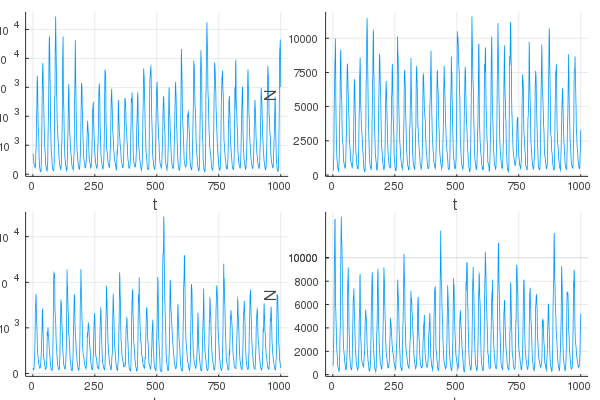

In [2]:
using StatsPlots
gr()
m = BlowFlyModel()
plot([plot(m(29, 260, .6, .3, 7, .2),
           xlabel = "t", ylabel = "N", legend = false) for _ in 1:4]...,
     layout = (2, 2))

To compare different realizations we will use histogram summary statistics.
In the literature one finds also other summary statistics for this data.

In [3]:
summary_statistics(N) = fit(Histogram, N, 140:16:16140).weights

summary_statistics (generic function with 1 method)

We will use a normal prior on log-transformed parameters.

In [4]:
function parameter(logparams)
    lP, lN₀, lσd, lσp, lτ, lδ = logparams
    (P = round(exp(2 + 2lP)),
    N₀ = round(exp(4 + .5lN₀)),
    σd = exp(-.5 + lσd),
    σp = exp(-.5 + lσp),
    τ = round(Int, max(1, min(500, exp(2 + lτ)))),
    δ = exp(-1 + .4lδ))
end
(m::BlowFlyModel)(logparams) = m(parameter(logparams)...)
target(m::BlowFlyModel) = [(log(29) - 2)/2,
                           (log(260) - 4)*2,
                           log(.6) + .5,
                           log(.3) + .5,
                           log(7) - 2,
                           (log(.2) + 1)/.4]
lower(m::BlowFlyModel) = fill(-5., 6)
upper(m::BlowFlyModel) = fill(5., 6)
prior = TruncatedMultivariateNormal(zeros(6), ones(6),
                                    lower = lower(m), upper = upper(m))

TruncatedMultivariateNormal{Distributions.MvNormal{Float64,PDMats.PDiagMat{Float64,Array{Float64,1}},Array{Float64,1}},Float64}(
mvnormal: DiagNormal(
dim: 6
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)

lower: [-5.0, -5.0, -5.0, -5.0, -5.0, -5.0]
upper: [5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
)


Let us now generate some target data.

In [5]:
model = BlowFlyModel()
x0 = target(model)
data = summary_statistics(model(x0))

1000-element Array{Int64,1}:
 1
 1
 0
 0
 0
 0
 2
 1
 8
 5
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0

## Adaptive SMC

In [6]:
smc = AdaptiveSMC(prior = prior)
result = run!(smc, x -> summary_statistics(model(x)), data,
              maxfevals = 2*10^5, verbose = false)
using PrettyTables
pretty_table([[keys(parameter(zeros(6)))...] quantile(smc, .05) median(smc) mean(smc) x0 quantile(smc, .95)],
             ["names", "5%", "median", "mean", "actual", "95%"],
             formatter = ft_printf("%10.3f"))

┌───────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│ names │         5% │     median │       mean │     actual │        95% │
├───────┼────────────┼────────────┼────────────┼────────────┼────────────┤
│     P │     -2.030 │      0.552 │      0.112 │      0.684 │      2.083 │
│    N₀ │     -1.775 │     -0.045 │     -0.073 │      3.121 │      1.761 │
│    σd │     -1.564 │     -0.099 │     -0.089 │     -0.011 │      1.447 │
│    σp │     -1.639 │     -0.029 │      0.067 │     -0.704 │      2.105 │
│     τ │     -1.451 │      0.262 │      0.246 │     -0.054 │      1.741 │
│     δ │     -1.498 │      0.068 │      0.090 │     -1.524 │      1.675 │
└───────┴────────────┴────────────┴────────────┴────────────┴────────────┘


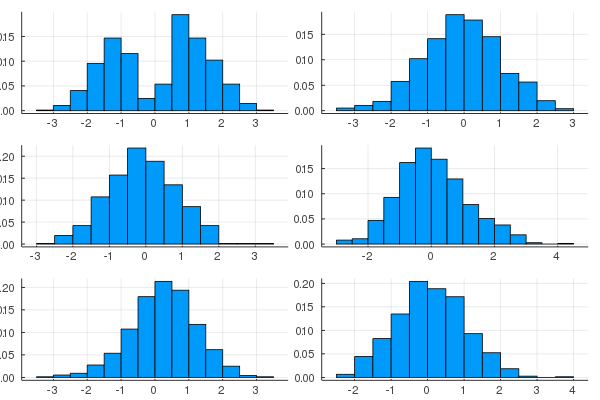

In [7]:
histogram(smc)

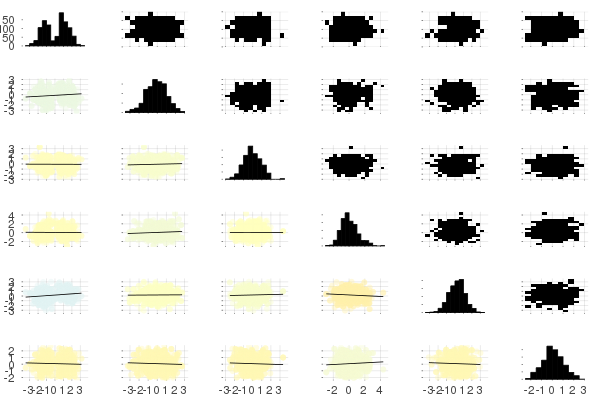

In [8]:
corrplot(smc)

## KernelABC

In [9]:
k = KernelABC(prior = prior, delta = 1e-1, K = 10^3, kernel = Kernel())
result = run!(k, x -> summary_statistics(model(x)), data)
pretty_table([[keys(parameter(zeros(6)))...] quantile(k, .05) median(k) mean(k) x0 quantile(k, .95)],
             ["names", "5%", "median", "mean", "actual", "95%"],
             formatter = ft_printf("%10.3f"))

┌───────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│ names │         5% │     median │       mean │     actual │        95% │
├───────┼────────────┼────────────┼────────────┼────────────┼────────────┤
│     P │     -1.799 │      0.476 │      0.179 │      0.684 │      1.916 │
│    N₀ │     -1.529 │      0.137 │      0.123 │      3.121 │      1.852 │
│    σd │     -1.673 │      0.008 │      0.032 │     -0.011 │      1.732 │
│    σp │     -1.744 │     -0.042 │      0.004 │     -0.704 │      1.835 │
│     τ │     -1.576 │      0.213 │      0.156 │     -0.054 │      1.691 │
│     δ │     -1.617 │     -0.036 │      0.000 │     -1.524 │      1.650 │
└───────┴────────────┴────────────┴────────────┴────────────┴────────────┘


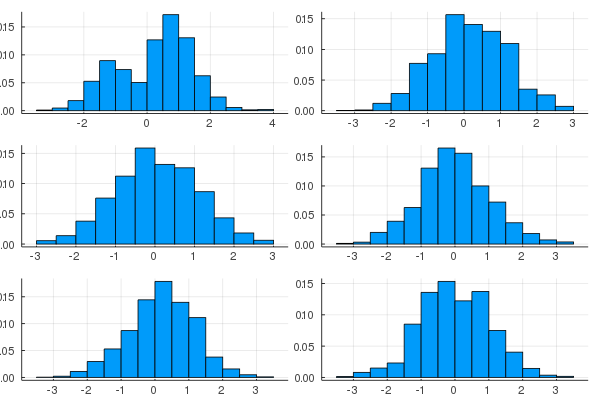

In [10]:
histogram(k)

## Kernel Recursive ABC (with callback)

In [11]:
k = KernelRecursiveABC(prior = prior,
                       K = 100,
                       delta = 1e-3,
                       kernel = Kernel(bandwidth = Bandwidth(heuristic = MedianHeuristic(2^3))),
                       kernelx = Kernel());

We will use a callback here to show how the estimated parameters evolves.

In [12]:
using LinearAlgebra
res_krabc = run!(k, x -> summary_statistics(model(x)), data,
                 maxfevals = 1300,
                 verbose = true,
                 callback = () -> @show norm(k.theta - x0)/norm(x0))

iteration         elapsed     fevals
norm(k.theta - x0) / norm(x0) = 1.0052746263543677
        1       0 seconds        100
norm(k.theta - x0) / norm(x0) = 1.0033268643994433
        2       2 seconds        200
norm(k.theta - x0) / norm(x0) = 0.9909581968957283
        3       4 seconds        300
norm(k.theta - x0) / norm(x0) = 0.9389119507524661
        4       5 seconds        400
norm(k.theta - x0) / norm(x0) = 0.9389119516270121
        5       6 seconds        500
norm(k.theta - x0) / norm(x0) = 0.9389119507036217
        6       7 seconds        600
norm(k.theta - x0) / norm(x0) = 0.9389119512413868
        7       8 seconds        700
norm(k.theta - x0) / norm(x0) = 0.9389119516686696
        8       8 seconds        800
norm(k.theta - x0) / norm(x0) = 0.9389119507864188
        9       9 seconds        900
norm(k.theta - x0) / norm(x0) = 0.9389119503956487
       10      10 seconds       1000
norm(k.theta - x0) / norm(x0) = 0.9389119497251093
       11      11 seconds       

(x = [0.927141336322695, 0.2299701164674767, 0.04011223027952103, 0.15244232679575095, 0.21971118270224926, -0.021451669917282333],)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*